## Import Packages

In [1]:
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split

import pandas as pd 
import random 
import numpy as np 
from torch import nn, optim 
import torch 

from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build Class

In [2]:
class GMF(nn.Module):
    def __init__(self, args):
        super(GMF, self).__init__()

        self.num_users = args.num_users 
        self.num_items = args.num_items 
        self.latent_dim = args.latent_dim 

        self.user_embedding = nn.Embedding(self.num_users, self.latent_dim)
        self.item_embedding = nn.Embedding(self.num_items, self.latent_dim)

        self.fc_layer = nn.Linear(args.latent_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, uid, iid):
        user_emb = self.user_embedding(uid)
        item_emb = self.item_embedding(iid)

        multiply_layer = torch.mul(user_emb, item_emb)
        # predict = torch.sum(multiply_layer, axis=1)
        predict = self.fc_layer(multiply_layer)
        # output = self.sigmoid(predict)
        return predict 

    def _init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, std=0.01)
            
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.zero_()

In [3]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

In [4]:
class MFDataset(Dataset):
    def __init__(self, dataframe):
        self.user_id = dataframe.user_id
        self.item_id = dataframe.business_id
        self.labels = dataframe.stars 

    def __len__(self):
        return len(self.user_id)

    def __getitem__(self, idx):
        uid = self.user_id[idx]
        iid = self.item_id[idx]
        label = self.labels[idx]

        return (
            torch.tensor(uid, dtype=torch.long), 
            torch.tensor(iid, dtype=torch.long), 
            torch.tensor(label, dtype=torch.float)
        )


In [5]:
def sentiment_score(x):
    if x >= 3.5 : return 1
    elif x < 3.5 : return 0
    
def train(args, model, train_loader, test_loader, optimizer, criterion):
    train_losses = []
    valid_losses = []
    best_loss = float('inf')

    set_seed(args)
    model = model.to(args.device)
    model.train()
    for epoch in tqdm(range(1, args.num_epochs + 1)):
        train_loss, valid_loss = 0.0, 0.0

        for batch in train_loader:
            batch = tuple(b.to(args.device) for b in batch)

            inputs = {'uid':    batch[0], 
                      'iid':    batch[1]}
            gold_y = batch[2]

            pred_y = model(**inputs).squeeze()
            loss = criterion(pred_y, gold_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        train_losses.append(train_loss)

        valid_loss = evaluate(args, model, test_loader, criterion)
        valid_losses.append(valid_loss)

        if epoch % 10 == 0 :
            print(f'Epoch: [{epoch}/{args.num_epochs}]')
            print(f'Train Loss: {train_loss:.5f}')
            print(f'Valid Loss: {valid_loss:.5f}')

        if best_loss > valid_loss:
            best_loss = valid_loss
            if not os.path.exists(args.SAVE_PATH):
                os.makedirs(args.SAVE_PATH)
            torch.save(model.state_dict(), os.path.join(args.SAVE_PATH, f'{model._get_name()}_parameters.pt'))
    
    return {
        'train_loss': train_losses, 
        'valid_loss': valid_losses
    }


def evaluate(args, model, test_loader, criterion):
    losses = 0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(b.to(args.device) for b in batch)

            inputs = {'uid':    batch[0], 
                      'iid':    batch[1]}
            gold_y = batch[2]

            pred_y = model(**inputs).squeeze()
                
            loss = criterion(pred_y, gold_y)
        
            losses += loss.item()
        losses /= len(test_loader)
    return losses


In [6]:
class args:
    seed = 42 
    batch_size = 512
    SAVE_PATH = os.path.join(os.getcwd(), 'baseline_parameters')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    lr = 1e-3

In [7]:
DATA_PATH = '../dataset/Yelp2018/Yelp2018.csv'
d_set = pd.read_csv(DATA_PATH, encoding='utf-8-sig')

d_set = d_set.astype({'user_id':'category', 'business_id':'category'})

# d_set.stars = d_set.stars.apply(sentiment_score)

In [8]:
from sklearn.preprocessing import MinMaxScaler

d_set.loc[:, 'stars'] = MinMaxScaler().fit_transform(d_set.loc[:, 'stars'].values.reshape(-1, 1))

In [9]:
d_train, d_test = train_test_split(d_set, train_size=0.6, random_state=args.seed)
d_valid, d_test = train_test_split(d_test, train_size=0.5, random_state=args.seed)

In [10]:
# d_train = d_train.astype({'user_id':'category', 'business_id':'category'})
# d_valid = d_valid.astype({'user_id':'category', 'business_id':'category'})
# d_test = d_test.astype({'user_id':'category', 'business_id':'category'})

In [11]:
d_train.shape, d_valid.shape, d_test.shape

((723952, 7), (241317, 7), (241318, 7))

In [12]:
u_cat = d_train.user_id.cat.categories
b_cat = d_train.business_id.cat.categories

In [13]:
d_valid.user_id = d_valid.user_id.cat.set_categories(u_cat)
d_valid.business_id = d_valid.business_id.cat.set_categories(b_cat)

d_test.user_id = d_test.user_id.cat.set_categories(u_cat)
d_test.business_id = d_test.business_id.cat.set_categories(b_cat)

In [14]:
d_train.user_id = d_train.user_id.cat.codes
d_train.business_id = d_train.business_id.cat.codes 

d_valid.user_id = d_valid.user_id.cat.codes
d_valid.business_id = d_valid.business_id.cat.codes 

d_test.user_id = d_test.user_id.cat.codes
d_test.business_id = d_test.business_id.cat.codes 

In [15]:
d_train = d_train.dropna()
d_valid = d_valid.dropna()
d_test = d_test.dropna()

d_train.reset_index(drop=True, inplace=True)
d_valid.reset_index(drop=True, inplace=True)
d_test.reset_index(drop=True, inplace=True)

In [16]:
args.num_users = d_train.user_id.max() + 1
args.num_items = d_train.business_id.max() + 1
args.latent_dim = 64
args.num_epochs = 30

In [17]:
model = GMF(args)

train_set = MFDataset(d_train)
valid_set = MFDataset(d_valid)
test_set = MFDataset(d_test)

train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=args.batch_size, num_workers=4)
test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=4)

optimizer = optim.SGD(model.parameters(), lr=args.lr)
# criterion = nn.BCELoss()
criterion = nn.L1Loss()

In [18]:
losses = train(args, model, train_loader, valid_loader, optimizer, criterion)

 33%|███▎      | 10/30 [00:52<01:45,  5.28s/it]

Epoch: [10/30]
Train Loss: 0.21106
Valid Loss: 0.21190


 67%|██████▋   | 20/30 [02:40<01:57, 11.78s/it]

Epoch: [20/30]
Train Loss: 0.21106
Valid Loss: 0.21190


100%|██████████| 30/30 [04:43<00:00,  9.44s/it]

Epoch: [30/30]
Train Loss: 0.21106
Valid Loss: 0.21189


In [19]:
test_loss = evaluate(args, model, test_loader, criterion)

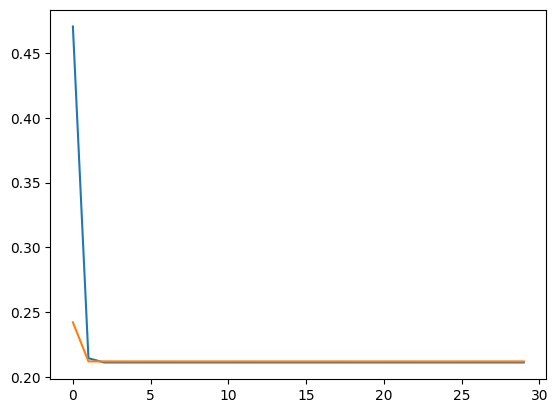

In [20]:
import matplotlib.pyplot as plt 

train_losses = losses['train_loss']
valid_losses = losses['valid_loss']

length = range(train_losses.__len__())

plt.plot(length, train_losses, '-')
plt.plot(length, valid_losses, '-')
plt.show()

In [21]:
def get_yhat(args, model, test_loader, criterion):
    y_hat = []
    losses = 0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(b.to(args.device) for b in batch)

            inputs = {'uid':    batch[0], 
                      'iid':    batch[1]}
            gold_y = batch[2]

            pred_y = model(**inputs).squeeze()
            y_hat.append(pred_y.detach().cpu())
                
            loss = criterion(pred_y, gold_y)
        
            losses += loss.item()
        losses /= len(test_loader)
    y_hat = torch.concat(y_hat)
    return y_hat

In [22]:
y_hat = get_yhat(args, model, test_loader, criterion)
d_test.loc[:, 'yhat'] = y_hat 

In [23]:
y_hat.shape

torch.Size([241317])

In [24]:

def accuracy(pred_y, true_y):
    pred_y = torch.sigmoid(pred_y)
    return ((pred_y > 0.5) == true_y).sum().detach().cpu().item()

def sentiment_score(x):
    if x >= 3.5 : return 1
    elif x < 3.5 : return 0

def dcg(label, k):
    label = np.asfarray(label)[:k]
    if label.size:
        return label[0] + np.sum(label[1:] / np.log2(np.arange(2, label.size + 1)))

    return 0

def ndcg(dataframe, k):
    ndcg_list = []
    for uid in dataframe.user_id.unique():
        label_temp = dataframe.loc[dataframe.user_id == uid]['stars'].tolist()

        idcg = dcg(sorted(label_temp, reverse=True), k)

        if not idcg:
            return 0 

        ndcg_list.append(dcg(label_temp, k) / idcg)
    return np.mean(ndcg_list)
    
def metrics(dataframe, top_k):
    # metrics for Sentiment Analysis
    item = dataframe.groupby(['user_id'])['stars'].sum()
    precision_k, recall_k, f1_k, ndcg_k = [], [], [], []
    for k in top_k:
        precision, recall, f1_score, ndcg_score = [], [], [], []
        for uid in tqdm(dataframe.loc[:, 'user_id'].unique(), desc=f'Tok@{k} evaluating..'):
            new_df = dataframe.loc[dataframe.loc[:, 'user_id'] == uid].copy()

            new_df = new_df.sort_values(by = ['yhat'], ascending=False).head(k)
            pr_temp = sum(new_df.loc[:, 'stars']) / k 
            re_temp = sum(new_df.loc[:, 'stars']) / item[uid] if item[uid] != 0 else 0 
            pr_re = pr_temp + re_temp 
            f1_temp = (2 * pr_temp * re_temp) / pr_re if pr_re != 0 else 0
            precision.append(pr_temp)
            recall.append(re_temp)
            f1_score.append(f1_temp)
            ndcg_score.append(ndcg(new_df, k))
        
        precision_k.append(np.mean(precision))
        recall_k.append(np.mean(recall))
        f1_k.append(np.mean(f1_score))
        ndcg_k.append(np.mean(ndcg_score))

    outputs = pd.DataFrame({
        'recall': recall_k, 
        'precision': precision_k, 
        'f1_score': f1_k, 
        'ndcg': ndcg_k
    }, index=top_k)
    return outputs 

In [25]:
results = metrics(d_test, [10, 20, 40, 50, 80, 100])

Tok@100 evaluating..: 100%|██████████| 25307/25307 [00:21<00:00, 1190.46it/s]


In [26]:
results 

,recall,precision,f1_score,ndcg
10,0.896257,0.496626,0.579262,0.908195
20,0.971753,0.304145,0.421222,0.907202
40,0.992255,0.166000,0.262055,0.907412
50,0.994342,0.134625,0.219943,0.907451
80,0.996144,0.085495,0.148339,0.907493
100,0.996513,0.068706,0.121974,0.907501
